In [1]:
import torch
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = "retina"


from typing import Any, Callable, List, Tuple, Dict

from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST, MNIST



from lightning.pytorch.utilities.types import STEP_OUTPUT, OptimizerLRScheduler
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.utils as vutils

import lightning.pytorch as L
from einops import rearrange, reduce, repeat

torch.manual_seed(2023)
np.random.seed(2023)
torch.set_float32_matmul_precision('medium')


In [2]:
trainset = FashionMNIST(root='~/.cache/torchvision_cache', train=True, download=True,
                        transform=transforms.Compose([
                        transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]))


Labels are all integers and their string descriptors are detailed here: https://www.kaggle.com/datasets/zalando-research/fashionmnist

(Why not just add them as metadata to the torchvision dataset?)

torch.Size([1, 28, 28])


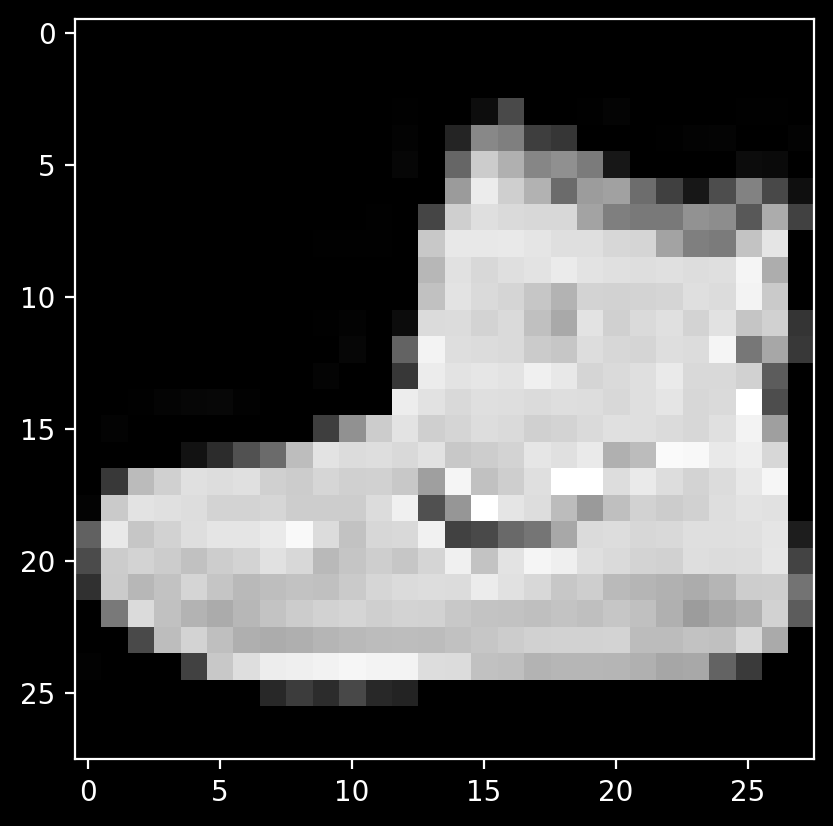

In [3]:
plt.imshow(trainset[0][0].squeeze(), cmap='gray')
print(trainset[0][0].size())


In [4]:
trainloader = DataLoader(trainset, batch_size=128, shuffle=True)


In [5]:
class Encoder(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        
        self.conv1 = nn.Conv2d(
            in_channels=1, 
            out_channels= 128,
            kernel_size=3,
            padding=1,
            stride=2
        )
        self.activation1 = nn.LeakyReLU()
        self.norm1 = nn.BatchNorm2d(128)
        
        self.conv2 = nn.Conv2d(
            in_channels=128,
            out_channels=64,
            kernel_size=3,
            padding=1,
            stride=2
        )
        self.activation2 = nn.LeakyReLU()
        self.norm2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(
            in_channels=64,
            out_channels=32,
            kernel_size=3,
            padding=1,
            stride=2
        )
        self.activation3 = nn.LeakyReLU()
        self.norm3 = nn.BatchNorm2d(32)
        
        self.dropout = nn.Dropout(0.1)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = self.conv1(x)
        out = self.activation1(out)
        
        out = self.conv2(out)
        out = self.activation2(out)

        out = self.conv3(out)
        out = self.activation3(out)
        
        out = self.dropout(out)
        
        return out



In [6]:
dummy_inputs = torch.randn(1, 1, 28, 28)

enc = Encoder()
with torch.no_grad():
    enc_out = enc(dummy_inputs)
    print(enc_out.size())


torch.Size([1, 32, 4, 4])


In [7]:
enc_out.flatten().size()


torch.Size([512])

In [8]:
class Decoder(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        
        self.trans_conv1 = nn.ConvTranspose2d(32, 64, 3, padding=1, stride=2, output_padding=0)
        self.norm1 = nn.BatchNorm2d(64)
        
        self.trans_conv2 = nn.ConvTranspose2d(
            64, 128, 3, padding=1, stride=2, output_padding=1)
        self.norm2 = nn.BatchNorm2d(128)
        
        self.trans_conv3 = nn.ConvTranspose2d(
            128, 1, 3, padding=1, stride=2, output_padding=1)
        self.norm3 = nn.BatchNorm2d(1)
        
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x: torch.Tensor):
        out = self.norm1(F.leaky_relu(self.trans_conv1(x)))
        out = self.norm2(F.leaky_relu(self.trans_conv2(out)))
        out = self.norm3(F.leaky_relu(self.trans_conv3(out)))
        
        out = self.sigmoid(out)
        return out
    
    
dec = Decoder()
with torch.no_grad():
    dec_out = dec(enc_out)
    print(dec_out.size())


torch.Size([1, 1, 28, 28])


In [9]:
assert dummy_inputs.size() ==  dec_out.size()


In [10]:
from typing import Any

from lightning.pytorch.utilities.types import STEP_OUTPUT, OptimizerLRScheduler


# gaussian factorised VAE
class VAE(L.LightningModule):
    def __init__(self, *args: Any, **kwargs: Any) -> None:
        super().__init__(*args, **kwargs)
        
        self.encoder = Encoder()
        self.flatten = nn.Flatten(start_dim=1)
        self.decoder = Decoder()
        
        # latent space
        self.mean = nn.Linear(512, 512)
        self.log_variance = nn.Linear(512, 512)
        
        # project to previous size
        # self.projection = nn.Linear(384, 512)
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 4, 4))
                
        
    def reparameterisation(self, mean, log_variance):
        std_dev = torch.exp(0.5 * log_variance)
        
        epsilon = torch.randn_like(std_dev).to(self.device)
        epsilon.requires_grad = True
        
        return mean + epsilon * std_dev
        
    def forward(self, x: torch.Tensor) -> Any:
        encoder_out = self.encoder(x)
        encoder_out = self.flatten(encoder_out)
        
        mean = F.leaky_relu(self.mean(encoder_out))
        log_variance = F.leaky_relu(self.log_variance(encoder_out))
        
        z = self.reparameterisation(mean, log_variance)
        # z = self.projection(z)
        # z = F.leaky_relu(z)
        z = self.unflatten(z)
        
        decoder_out = self.decoder(z)
        
        # x_hat, mean, log_sigma_2
        return decoder_out, mean, log_variance
    
    
    def configure_optimizers(self) -> OptimizerLRScheduler:
        return optim.AdamW(self.parameters(), lr=0.0005)
    
    
    def training_step(self, batch, batch_idx) -> STEP_OUTPUT:
        x, _ = batch
        x_hat, mean, log_variance = self(x)
        
        loss = F.binary_cross_entropy(x_hat, x, reduction="sum")
        kl = -0.5 * torch.sum(1 + log_variance - mean.pow(2) - log_variance.exp())
        loss += kl
        
        
        self.log('train_loss', loss, prog_bar=True)
        
        return {
            "loss": loss,
            "log": {
                "Loss/Training": loss
            }
        }
        
    

# vae = VAE()
# with torch.no_grad():
#     out, mean, log_variance = vae(dummy_inputs)
#     print(out.size())
        
        
def train() -> Any:
    logger = L.loggers.TensorBoardLogger(
        "tb_logs", name="vae_cnn_fashion_mnist", log_graph=True)

    model = VAE()
    trainer = L.Trainer(max_epochs=5, devices=1,
                        accelerator="gpu", logger=logger)
    trainer.fit(model, trainloader)

    return model


model = train()


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
-------------------------------------------
0 | encoder      | Encoder   | 94.0 K
1 | flatten      | Flatten   | 0     
2 | decoder      | Decoder   | 93.9 K
3 | mean         | Linear    | 262 K 
4 | log_variance | Linear    | 262 K 
5 | unflatten    | Unflatten | 0     
-------------------------------------------
713 K     Trainable params
0         Non-trainable params
713 K     Total params
2.853     Total estimated model params size (MB)
/home/shawon/miniconda3/envs/exp/lib/python3.10/site-packages/lightning/pytorch/loggers/tensorboard.py:187: Could not log computational graph to TensorBoard: The `model.example_input_array` attribute is not set or `input_array` was not given.
/home/shawon/miniconda3/envs/exp/lib/python3.10/site-packages/lightning/pytorc

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


torch.Size([1, 1, 28, 28])


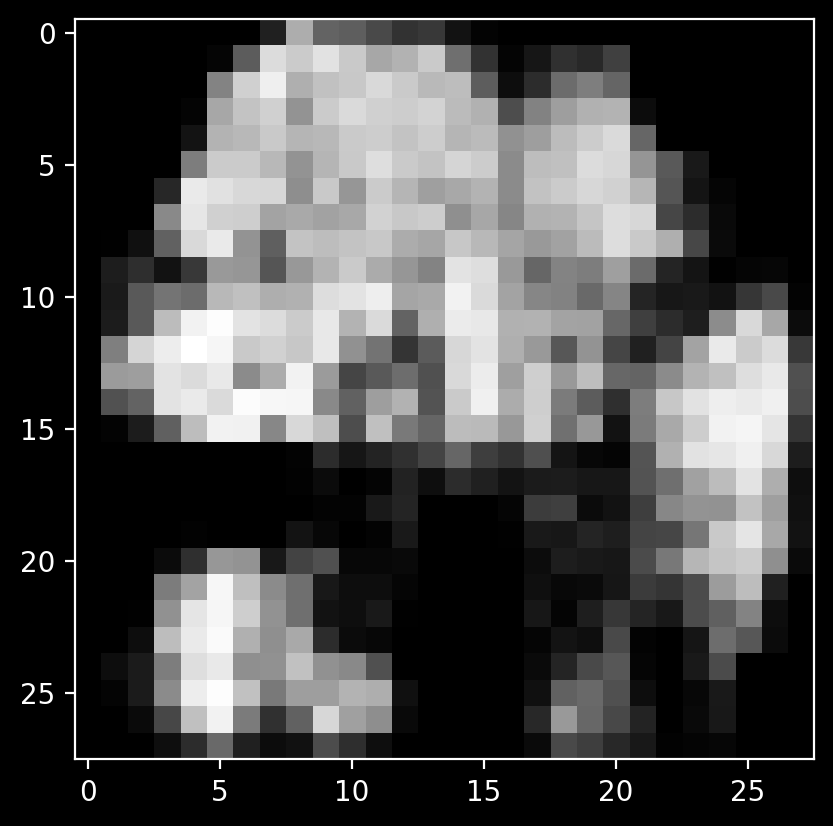

In [11]:
with torch.no_grad():
    x = torch.randn(1, 1, 28, 28).to(model.device) / 255.0
    out, _ , _ = model(x)

    print(out.size())

    plt.imshow(out.squeeze(), cmap='gray')


torch.Size([1, 1, 28, 28])


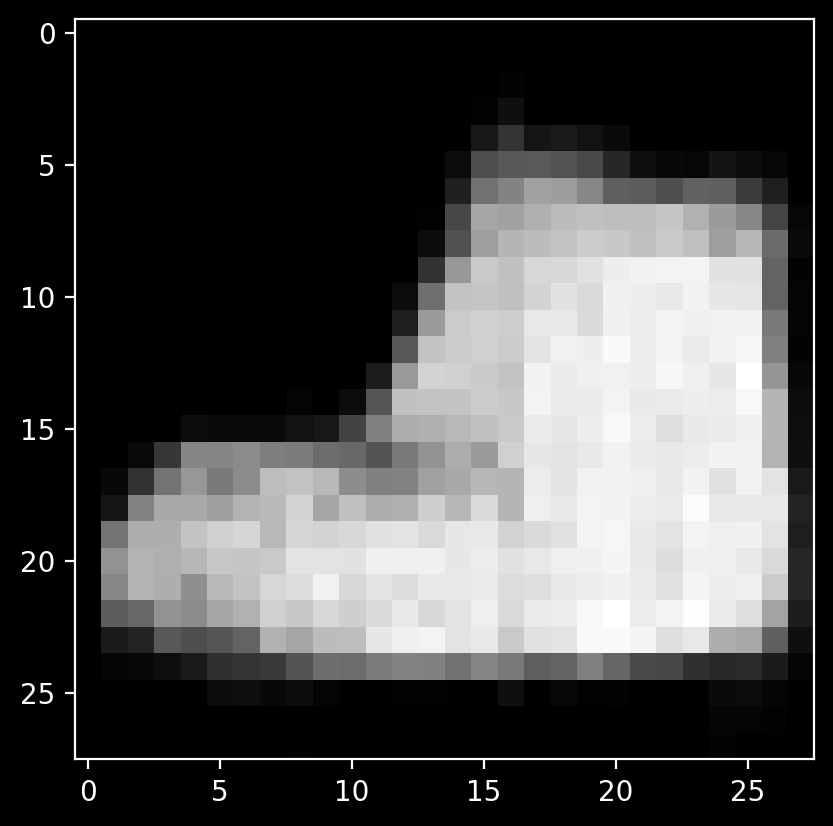

In [12]:
with torch.no_grad():
    x = trainset[0][0].unsqueeze(0).to(model.device)
    out, _, _ = model(x)

    print(out.size())

    plt.imshow(out.squeeze(), cmap='gray')


In [13]:
@torch.no_grad()
def infer(x, model = model):
    x = x.to(model.device)
    out, _, _ = model(x)
    return out


In [14]:
def comparison(idx):
    fig = plt.figure(1, figsize=[9, 5])
    fig.tight_layout()
    
    # get 3 generated images
    vae_images = [infer(trainset[idx][0].unsqueeze(0)) for _ in range(3)]
    
    ax = fig.add_subplot(1, 4, 1)
    ax.set_title("Actual")
    plt.imshow(trainset[idx][0].squeeze(), cmap="gray")
    plt.axis("off")
    
    
    for im_idx, vae_im in enumerate(vae_images):
        ax = fig.add_subplot(1, 4, im_idx + 1 + 1)
        ax.set_title(f"VAE_{im_idx}")
        plt.imshow(vae_im.squeeze(), cmap='gray')
        plt.axis("off")
    
    fig.suptitle("Actual vs VAE")
    plt.show()


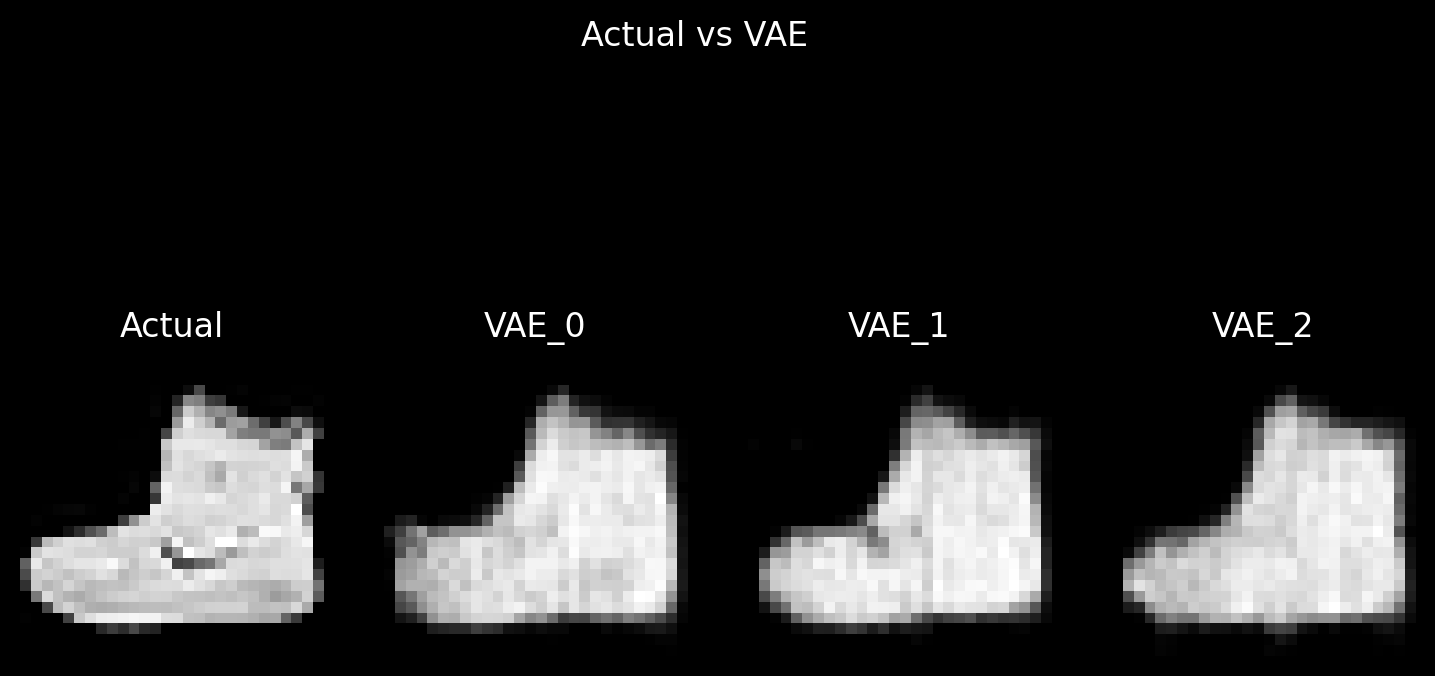

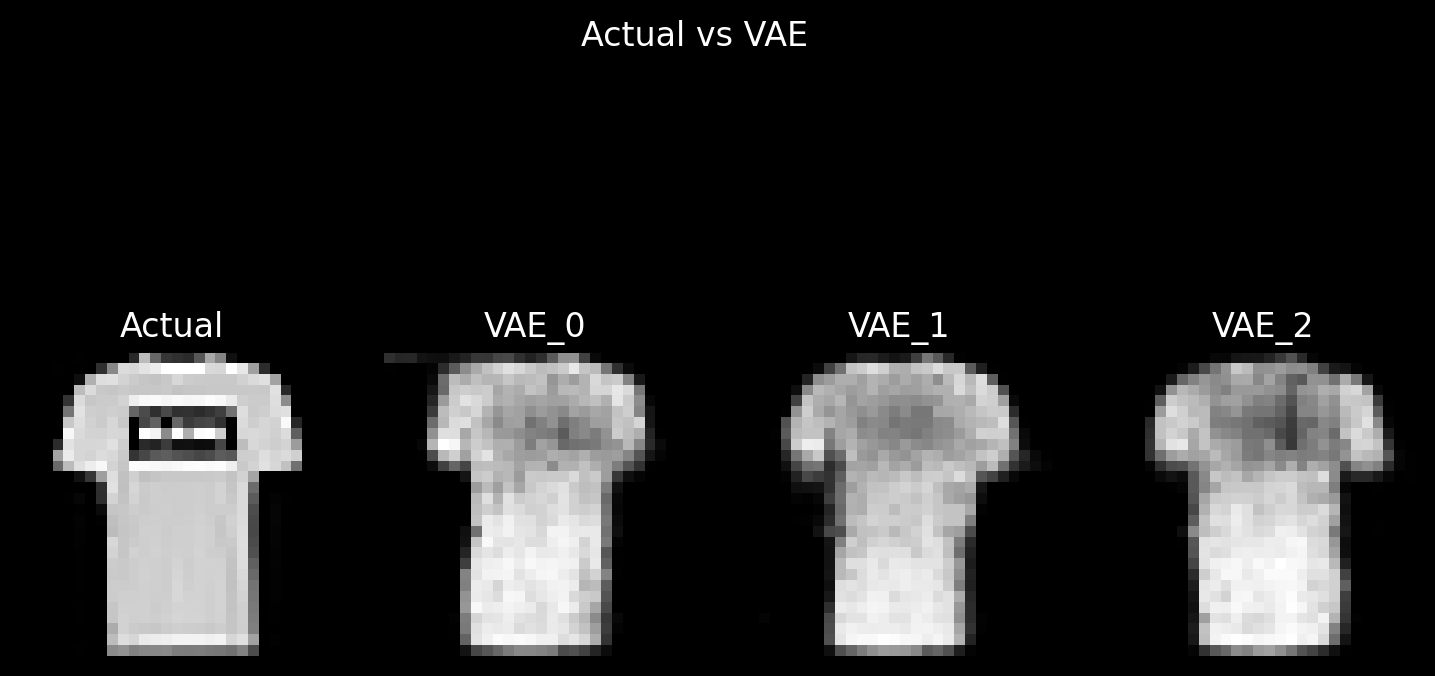

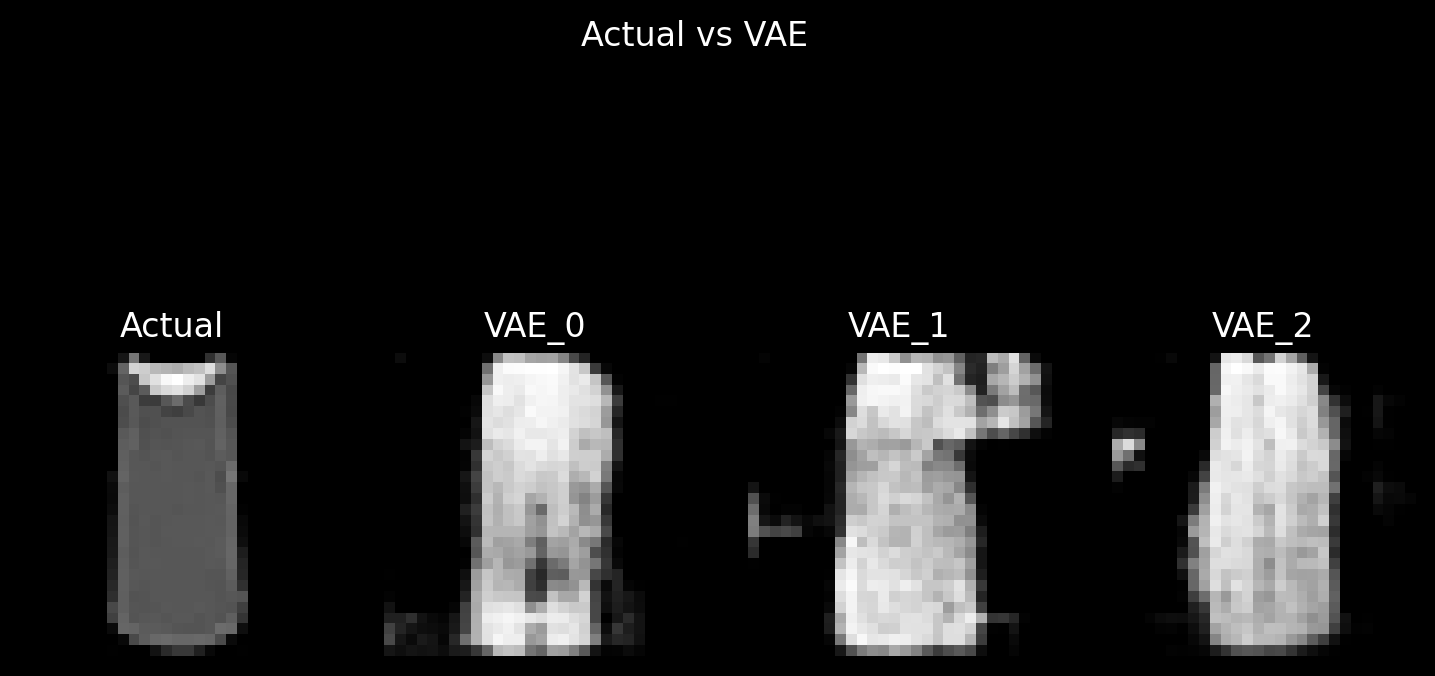

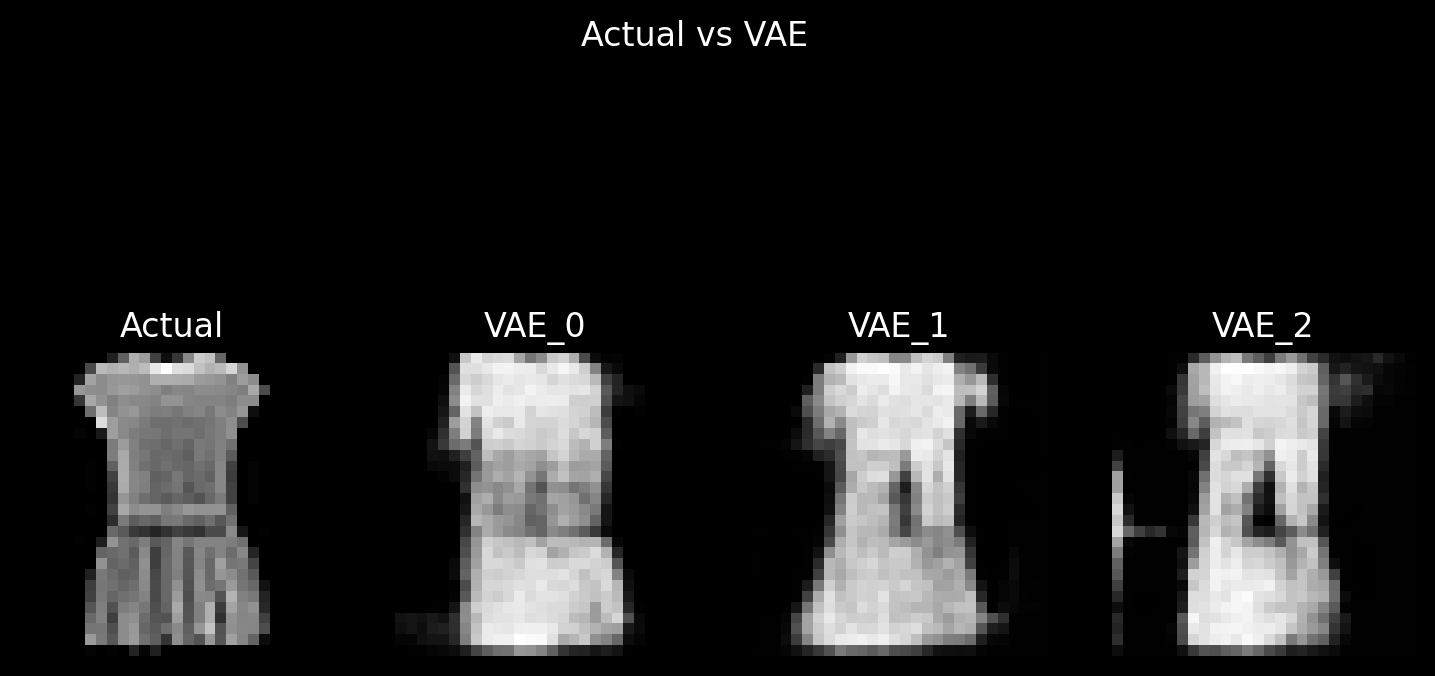

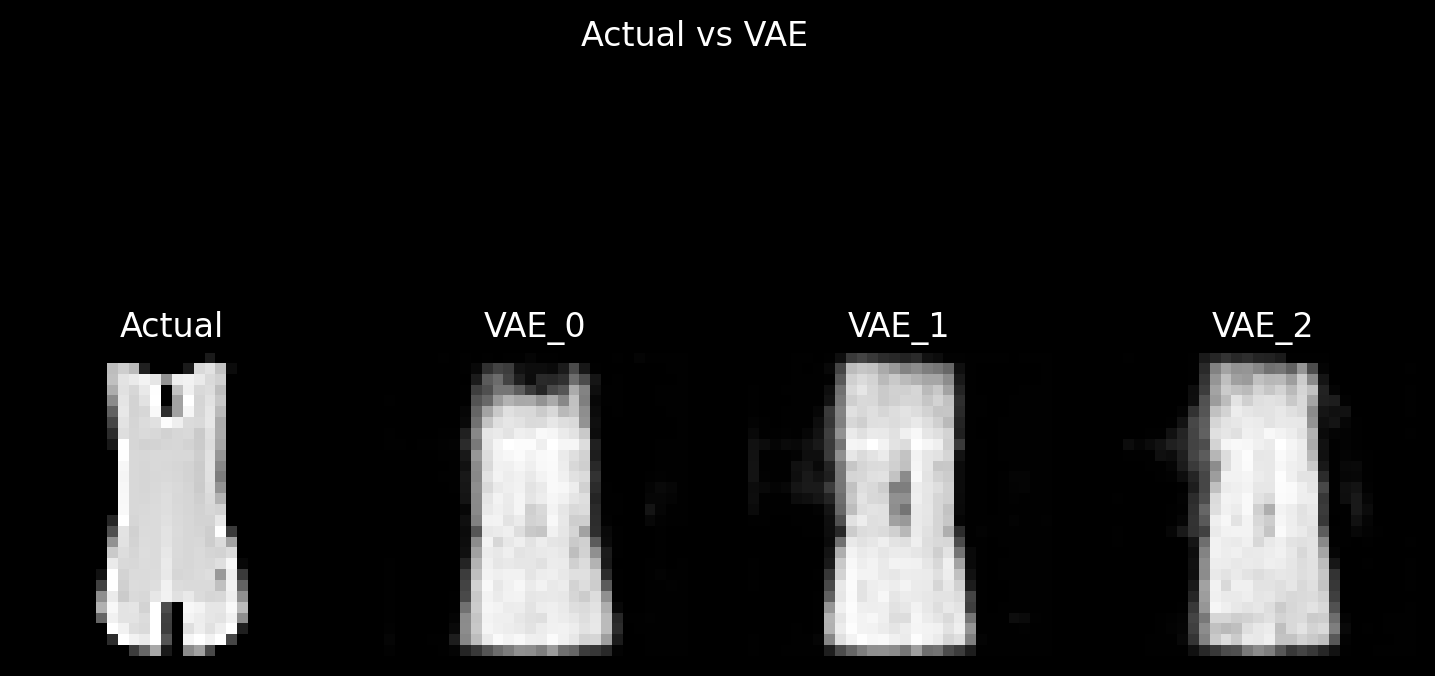

In [15]:
for i in range(5):
    comparison(i)
